In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, plot_precision_recall_curve, make_scorer, recall_score, brier_score_loss, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# libraries for cleaning
import re
import nltk
nltk.download("stopwords") # helps us get rid of stop words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Exploration

At this moment, will explore the hydrated data since it contains time.

Resources on text analysis: 
https://www.tensorflow.org/hub/tutorials/tf2_text_classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/text_preprocessed.csv")

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,25,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221461 entries, 0 to 221460
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    221461 non-null  object
 1   label   221461 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,text,label
0,coronavirus outbreak live updates odisha conf...,0
1,for today may here s how to follow the lat...,0
2,coronavirus outbreak round the clock updates ...,0
3,watch live gov phil murphy will speak at p...,0
4,to all my friends in the people s republic of ...,0


In [ ]:
df.loc[df.label == 1,:].head()

,text,label
210886,why big pharma fauci and bill gates want to ...,1
210887,blue skies smiling at me ...,1
210888,pentagon confirms coronavirus accidently got i...,1
210889,people of color may be immune to the coronavir...,1
210890,[news] pentagon confirms coronavirus accidentl...,1


**IMPORTANT**: 

- real news = 0
- fake news = 1 

# Bag of Words Model - Count Vectorizer

1. Assign a fixed integer id to each word that occurs in the twets of the training set
2. For each tweet. count the number of occurences of each word and store it 

As a result, the n_features parameter ends up being the number of distinct words in the training set 

## Term Frequency times Inverse Document Frequency (TF-IDF)

Now we can divide the number of occurences of each word in a document by the total number of words in the doc. This is applied after using Count Vectorizer(). 

According to documentation: *The goal of using tf-idf instead of the raw frequencies of occurrence of a
token in a given document is to scale down the impact of tokens that occur
very frequently in a given corpus and that are hence empirically less
informative than features that occur in a small fraction of the training
corpus.*

**A con of TF-IDF is that very short texts are likely to have noisy tf-idf values - this is why we get better results with CountVectorizer().** 

Additionally, it's important to focus on having a better recall value vs precision. This is because new fake phrases are always being introduced, so it's better that we flag for fake news to reduce the spread, vs wasting more time being precise and then having it proliferate.

In [ ]:
def cleaning_words(phrase):
  tweet = re.sub(r"http\S+", "", phrase) # remove all URLs
  tweet = re.sub('[^a-zA-z]',' ',tweet) # remove punctuation
  tweet = re.sub(r'@\S+|https?://\S+','', tweet) # remove @ sign
  tweet = tweet.lower() # make all letters lower case
  #tweet = tweet.split() # make a list of the words

  # now will stem words 
  # ps = PorterStemmer()
  # all_stopwords = stopwords.words("english")
  # all_stopwords.remove("not") # make sure we don't remove the word "not" since that changes the meaning of the sentence
  # tweet = [ps.stem(t) for t in tweet if not t in set(all_stopwords)]
  # tweet = " ".join(tweet) # join the words back together
  cleaned_words = []
  cleaned_words.append(tweet)
  return cleaned_words

In [ ]:
# split into training vs testing data

X = df.text
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=0)

# create a sparse matrix 
cv = CountVectorizer(stop_words=stopwords.words("english"))
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)
#X_val = cv.transform(X_val)
feature_names = cv.get_feature_names()


In [ ]:
print(feature_names[5000:5010])

['amref_kenya', 'amref_worldwide', 'amrefethiopia', 'amrel', 'amrink', 'amrita', 'amrithajayanti', 'amrschar', 'amrstaff', 'ams']


In [ ]:
# a ton of unique words! (166095 to be exact)
X_train.shape

(166095, 127394)

In [ ]:
# now apply TF-IDf
# tf = TfidfTransformer(use_idf = True).fit(X_train)
# X_train = tf.transform(X_train)
# X_test = tf.transform(X_test)

## Naive Bayes Model

With this model, we assume that the data from each label is drawn from a simple Gaussian distribution. So all we do is find
the mean and standard deviation of the points within each label to define the distribution. This is good to use as a baseline model - then we can try other models to see if they can beat this really simple one. 

Another important thing to note is that the data is highly skewed - will need to take this into consideration. 

**Advantages:** 
- fast for training & prediction
- has probabilistic interpretation 
- not a lot of parameters (more simple)

Good example of implementation: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# find baseline accuracy
fake_count = df[df.label == 1].count()[0]
real_count = df[df.label == 0].count()[0]

perc_f = fake_count/df.shape[0]
perc_r = real_count/df.shape[0]

print(f"{perc_f} of the data is fake")
print(f"{perc_r} of the data is real")

0.04775107129472007 of the data is fake
0.9522489287052799 of the data is real


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# fit the model
model_mb = MultinomialNB()
params = {"alpha":[0.001, 0.01, 0.05, 0.1, 0.5]}

model_mb_grid = GridSearchCV(model_mb, params,n_jobs=1, verbose = 1, scoring = "f1")
model_mb_grid.fit(X_train,y_train)
best_params = model_mb_grid.best_params_
print(best_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.001}


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.8s finished


In [ ]:
# alpha = model_mb_grid.best_params_.get('alpha')
model_mb = MultinomialNB()
model_mb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# find performance on training vs test data
y_test_pred = model_mb.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

#1       0.92      0.20      0.33      3150

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     52750
           1       0.86      0.65      0.74      2616

    accuracy                           0.98     55366
   macro avg       0.92      0.82      0.86     55366
weighted avg       0.98      0.98      0.98     55366



In [ ]:
# since NB also gives probabilities, we can calculate the Brier Score 
y_train_pred_prob = model_mb.predict_proba(X_train)[:,1]
y_test_pred_prob = model_mb.predict_proba(X_test)[:,1]

brier_train = brier_score_loss(y_train, y_train_pred_prob)
brier_test = brier_score_loss(y_test, y_test_pred_prob)
print(brier_train)
print(brier_test)

0.016475714331496513
0.019146971666734004


0.9471204798759367


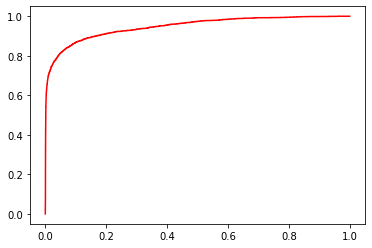

In [ ]:
# because naive bayes is a probabilistic model we can also make an ROC curve 
# and we can find the AUC as well 
fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob)
auc_val = auc(fpr, tpr)
print(auc_val)
plt.figure()
plt.plot(fpr, tpr, color = "red", label = f"ROC Cruve with AUC {auc_val}")
plt.show()
# looks like a threshold of 0.1 might be ideal

# to find the optimal cutoff, we want the tpr to be very high and the fpr needs to be very low
# so tpr - (1-fpr) needs to be near 0 (closer to zero means better cutoff)
#optimal = thresh[np.argmax(tpr-fpr)] # youden's stat
#print(optimal)
# threshold too small - ignore for now, might include in future steps

[[52469   281]
 [  925  1691]]


Text(91.68, 0.5, 'predicted labels testing data')

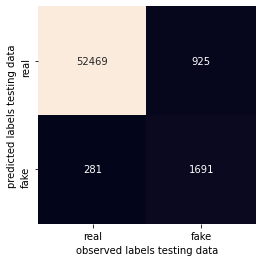

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
sns.heatmap(cm.T, square = True, annot=True, fmt = "d", cbar = False, 
            xticklabels = ["real","fake"], yticklabels = ["real","fake"])
plt.xlabel("observed labels testing data")
plt.ylabel("predicted labels testing data")

In [ ]:
random_text = "Please get vaccinated - it'll stop the spread"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model_mb.predict(random_text))
print(model_mb.predict_proba(random_text))

random_text = "fauci and bill gates want to ban hydroxychloroquine"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model_mb.predict(random_text))
print(model_mb.predict_proba(random_text))


random_text = "We need lockdowns! COVID-19 isn't just the flu!"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model_mb.predict(random_text))
print(model_mb.predict_proba(random_text))

random_text = "More lockdowns more problems - the elite are trying to trap us"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model_mb.predict(random_text))
print(model_mb.predict_proba(random_text))

[0]
[[9.99574427e-01 4.25572790e-04]]
[1]
[[0.03483046 0.96516954]]
[0]
[[9.99894906e-01 1.05094210e-04]]
[0]
[[9.99522680e-01 4.77320309e-04]]


## Types of Naive Bayes


Good explanation: https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes

Good paper: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.61.5542 
https://www.researchgate.net/publication/221650814_Spam_Filtering_with_Naive_Bayes_-_Which_Naive_Bayes

sklearn documentation: https://scikit-learn.org/stable/modules/naive_bayes.html


**Multi-variate Bernoulli Naive Bayes**:

This model treats each message as a set of tokens (ie predetermined words/features. Usually just pick the top 1000 words that appear in the data). So now we can represent each message as a *binary* vector x where each $x_i$ shows whether or not each token word appears in our message. That is what we are doing when we make a *sparse matrix*. 

According to the sklearn documentation, the Complement Naive Bayes is good for imbalanced data set and is a type of multinomial naive bayes. 

**Multinomial Naive Bayes**: 
A generalization of the binomial distribution. So obviously we have more than just two words in our entire vocabulary/text. So using multinomial naive bayes basically just lets us know that there is a multinomial distribution for each of the features (ie columns in our sparse matrix). 

The way the paper explains it is that instead of just representing each message as a vector with indicators of 1 vs 0 for each token (remember token = max_features/words we want to look at) instead we have a count. So we see *how many times* each token is in the message.

This means when I want to implement this model I need to use CountVectorizer() instead of TF-IDF().  

However there is a multinomial naive bayes with **boolean** (ie binary) attributes. This is very similar to the multi-variate bernoulli NB model but it does not consider the cases where x_i = 0 (ie when the token word does not appear in our message). I don't think I will use this for now. 

**Multi-variate**:
It seems like this is used when our vector x (which represents the occurence of a token or not) is *real valued*. So this means it's not binary (0 vs 1) it can be decimals as well! This is what I used initially and explains why the Gaussian model got better when I used TF-IDF (TF-IDF standardizes values, so that means we get decimals in the model). My sparse matrix is better suited for a Multi-variate Bernoulli (using TF-IDF) or Multinomial naive bayes model (using CountVectorizer()). 

I will implement the ComplementNB() model because it is a multinomial NB but it deals with imbalanced datasets much better. 

In [ ]:
from sklearn.naive_bayes import ComplementNB

In [ ]:
# fit the model
model_cb = ComplementNB()
params = {"alpha":[0.001, 0.01, 0.05, 0.1, 0.5]}

model_cb_grid = GridSearchCV(model_cb, params,n_jobs=1, verbose = 1, scoring = "f1")
model_cb_grid.fit(X_train,y_train)
best_params = model_cb_grid.best_params_
print(best_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.001}


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.8s finished


In [ ]:
# fit the model
model = ComplementNB()
model.fit(X_train, y_train)

# find performance on training vs test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# cross validation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

# since NB also gives probabilities, we can calculate the Brier Score 
y_train_pred_prob = model.predict_proba(X_train)[:,1]
y_test_pred_prob = model.predict_proba(X_test)[:,1]

brier_train = brier_score_loss(y_train, y_train_pred_prob)
brier_test = brier_score_loss(y_test, y_test_pred_prob)
print(brier_test)

#1       0.70      0.52      0.60      3150

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     52750
           1       0.62      0.76      0.68      2616

    accuracy                           0.97     55366
   macro avg       0.80      0.87      0.83     55366
weighted avg       0.97      0.97      0.97     55366

0.027248154511399024


[[51513  1237]
 [  639  1977]]


Text(91.68, 0.5, 'predicted labels testing data')

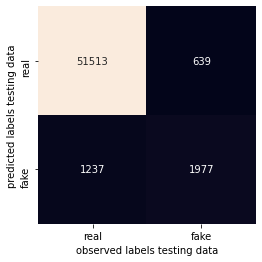

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
sns.heatmap(cm.T, square = True, annot=True, fmt = "d", cbar = False, 
            xticklabels = ["real","fake"], yticklabels = ["real","fake"])
plt.xlabel("observed labels testing data")
plt.ylabel("predicted labels testing data")

In [ ]:
# because naive bayes is a probabilistic model we can also make an ROC curve 
# and we can find the AUC as well 

fpr, tpr, _ , = roc_curve(y_test, y_test_pred_prob)
auc(fpr, tpr)

0.947126900444947

Interesting that when I apply cleaning to the new data, the model works badly... not sure what is causing this!

In [ ]:
random_text = "Please get vaccinated - it'll stop the spread"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model.predict(random_text))
print(model.predict_proba(random_text))

random_text = "fauci and bill gates want to ban hydroxychloroquine"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model.predict(random_text))
print(model.predict_proba(random_text))

random_text = "We need lockdowns! COVID-19 isn't just the flu!"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model.predict(random_text))
print(model.predict_proba(random_text))

random_text = "More lockdowns more problems - the elite are trying to trap us"
random_text = cleaning_words(random_text)
random_text = cv.transform(random_text)
#random_text = tf.transform(random_text)
print(model.predict(random_text))
print(model.predict_proba(random_text))

[0]
[[0.99161173 0.00838827]]
[1]
[[0.00181299 0.99818701]]
[0]
[[0.99791603 0.00208397]]
[0]
[[0.99060086 0.00939914]]


One thing to note: when I performed grid search I played around with the alpha value. But later on I realized because we are working with tweets, the alpha needs to be 1. When $\alpha = 1$ it is called Laplace smoothing. The reason we should implement laplace smoothing is that when a new word appears in a text (that the model has not seen in training) if we don't use laplace smoothing the NB model assigns that new word a probability of 0 which makes the posterior probabilities drop to zero. The result is that the model is just completely unable to make predictions if it hasn't seen that **exact** word/phrase before (so all predictions will just be the real class). Laplace smoothing thus fixes this problem by giving that new word a small probability for both the fake/real classes to prevent that from happening. 

# Final Results 

Test on the new dataset. I used the preprocessing code to create a function to clean words, and included stop word removal in the `CountVectorizer()` function.

In [ ]:
test_final = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/english_test_with_labels.csv")
test_final = test_final.iloc[:,1:]
print(test_final.head())
label_change = lambda x: 1 if x == "fake" else 0
y = test_final.iloc[:,1]
test_final.iloc[:,1] = y.map(label_change)
print(test_final.head())

                                               tweet label
0  Our daily update is published. States reported...  real
1             Alfalfa is the only cure for COVID-19.  fake
2  President Trump Asked What He Would Do If He W...  fake
3  States reported 630 deaths. We are still seein...  real
4  This is the sixth time a global health emergen...  real
                                               tweet  label
0  Our daily update is published. States reported...      0
1             Alfalfa is the only cure for COVID-19.      1
2  President Trump Asked What He Would Do If He W...      1
3  States reported 630 deaths. We are still seein...      0
4  This is the sixth time a global health emergen...      0


In [ ]:
def cleaning_words2(phrase):
  tweet = re.sub(r"http\S+", "", phrase) # remove all URLs
  tweet = re.sub('[^a-zA-z]',' ',tweet) # remove punctuation
  tweet = re.sub(r'@\S+|https?://\S+','', tweet) # remove @ sign
  tweet = tweet.lower() # make all letters lower case
  #tweet = tweet.split() # make a list of the words

  # now will stem words 
  # ps = PorterStemmer()
  # all_stopwords = stopwords.words("english")
  # all_stopwords.remove("not") # make sure we don't remove the word "not" since that changes the meaning of the sentence
  # tweet = [ps.stem(t) for t in tweet if not t in set(all_stopwords)]
  # tweet = " ".join(tweet) # join the words back together
  cleaned_words = []
  cleaned_words.append(tweet)
  return tweet

In [ ]:
X_test_final = test_final.iloc[:,0]
y_test_final = test_final.iloc[:,1]
print(X_test_final[:3])
print(y_test_final[:3])

# clean & transform
X_test_final = X_test_final.map(cleaning_words2)
X_test_final = cv.transform(X_test_final)

0    Our daily update is published. States reported...
1               Alfalfa is the only cure for COVID-19.
2    President Trump Asked What He Would Do If He W...
Name: tweet, dtype: object
0    0
1    1
2    1
Name: label, dtype: int64


In [ ]:
# multinomial model results
y_test_final_pred = model_mb.predict(X_test_final)
print(classification_report(y_test_final, y_test_final_pred))

              precision    recall  f1-score   support

           0       0.53      1.00      0.70      1120
           1       1.00      0.04      0.08      1020

    accuracy                           0.54      2140
   macro avg       0.77      0.52      0.39      2140
weighted avg       0.76      0.54      0.40      2140



In [ ]:
# complement model results
y_test_final_pred = model_cb.predict(X_test_final)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1120
           1       1.00      0.10      0.19      1020

    accuracy                           0.57      2140
   macro avg       0.78      0.55      0.45      2140
weighted avg       0.76      0.57      0.46      2140

